##### Importacao de bibliotecas e banco de dados

In [109]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
from pandas.core.series import Series
from pandas.core.frame import DataFrame

In [110]:
base_path = Path("database")
base_airbnb = pd.DataFrame()
for file in base_path.iterdir():
    if file.name.endswith(".csv"):
        month_df = pd.read_csv(base_path / file.name)
        month_df['last_scraped'] = pd.to_datetime(month_df['last_scraped'])
        month_df['year'] = month_df['last_scraped'].dt.year
        month_df['month'] = month_df['last_scraped'].dt.month
        base_airbnb = pd.concat([base_airbnb, month_df], ignore_index=True)


/tmp/ipykernel_15326/3276474334.py:5: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  month_df = pd.read_csv(base_path / file.name)
/tmp/ipykernel_15326/3276474334.py:5: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  month_df = pd.read_csv(base_path / file.name)
/tmp/ipykernel_15326/3276474334.py:5: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  month_df = pd.read_csv(base_path / file.name)
/tmp/ipykernel_15326/3276474334.py:5: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  month_df = pd.read_csv(base_path / file.name)
/tmp/ipykernel_15326/3276474334.py:5: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  month_df = pd.read_csv(base_path / file.name)
/tmp/ipykernel_15326/3276474334.py:5: Dty

##### Limpeza do dataset

Como tempo muitas colunas no nosso dataset, o modelo fica mais lento.

Uma análise será feita para retirar as colunas que não serão necessárias para o nosso modelo de previsao.

colunas que serão excluídas:

- IDs, links e informações nao relevantes ao modelo.
- criada colunas separadas para ano e mes de extracao (mais util para a análise), excluindo a coluna com a data completa
- Colunas preenchidas com texto livre (nao será utilizado nenhuma análise de palavras, ou LLM, focando-se um modelo mais simples)
- colunas com todos (ou proximo a isso) são iguais
- precos que nao sejam diarios
- informacoes fiscais exigidas (análise busca verificar características do imovel)

In [111]:
print(list(base_airbnb.columns))

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

In [112]:
columns = [
    "host_response_time",
    "host_response_rate",
    "host_is_superhost",
    "host_listings_count",
    "latitude",
    "longitude",
    "property_type",
    "room_type",
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "bed_type",
    "amenities",
    "price",
    "security_deposit",
    "cleaning_fee",
    "guests_included",
    "extra_people",
    "minimum_nights",
    "maximum_nights",
    "number_of_reviews",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
    "instant_bookable",
    "is_business_travel_ready",
    "cancellation_policy",
    "year",
    "month",
]
base_airbnb = base_airbnb.loc[:, columns]
display(base_airbnb)

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,year,month
0,within an hour,100%,t,2.0,-22.965920,-43.178960,Condominium,Entire home/apt,5,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict_14_with_grace_period,2019,11
1,within a day,91%,f,3.0,-22.977120,-43.190450,Apartment,Entire home/apt,2,1.0,...,10.0,9.0,10.0,10.0,9.0,f,f,strict_14_with_grace_period,2019,11
2,within an hour,100%,t,1.0,-22.983020,-43.214270,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,10.0,t,f,strict_14_with_grace_period,2019,11
3,within an hour,100%,t,1.0,-22.988160,-43.193590,Apartment,Entire home/apt,3,1.5,...,9.0,10.0,10.0,10.0,9.0,f,f,strict_14_with_grace_period,2019,11
4,within an hour,100%,t,1.0,-22.981270,-43.190460,Loft,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,10.0,f,f,strict_14_with_grace_period,2019,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,within an hour,100%,t,22.0,-22.982284,-43.190167,Apartment,Entire home/apt,4,1.5,...,NaN,NaN,NaN,NaN,NaN,t,f,strict_14_with_grace_period,2018,7
902206,within a day,80%,f,2.0,-23.019163,-43.488247,Serviced apartment,Private room,2,1.0,...,NaN,NaN,NaN,NaN,NaN,t,f,moderate,2018,7
902207,within a day,60%,f,19.0,-22.964826,-43.177641,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,t,f,flexible,2018,7
902208,NaN,NaN,f,1.0,-22.890793,-43.440360,House,Entire home/apt,7,2.0,...,NaN,NaN,NaN,NaN,NaN,t,f,flexible,2018,7


#### Tratando dados Faltantes

Visualizando os dados, percebemos que existem uma grande disparidade em dados faltantes.
- as colunas comm mais de 300 mil valores nulos foram excluidas da análise
- Para as demais colunas, como temos mais de 900 mil linhas, vamos simplesmente exlcuir com os dados nulos

In [113]:
print(base_airbnb.isnull().sum())
for column in base_airbnb:
    if base_airbnb[column].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(column, axis=1)
print(base_airbnb.shape)

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

In [114]:
base_airbnb = base_airbnb.dropna()
print(base_airbnb.isnull().sum())
print(base_airbnb.shape)

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
year                        0
month                       0
dtype: int64
(897709, 23)


In [115]:
print(base_airbnb.dtypes)
print("-"*60)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
year                          int32
month                         int32
dtype: object
------------------------------------------------------------
host_is_superhost                                                           t
host_listings_count

Como preço e extra_people estão sendo reconhecidos como objeto ao ines de float, tempo de mudar o tipo de variável da coluna

In [116]:
# alterar price, extra_people
base_airbnb["price"] = base_airbnb["price"].str.replace("$", "").str.replace(",", "")
base_airbnb["price"] = base_airbnb["price"].astype(np.float32, copy=False)
base_airbnb["extra_people"] = base_airbnb["extra_people"].str.replace("$", "").str.replace(",", "")
base_airbnb["extra_people"] = base_airbnb["extra_people"].astype(np.float32, copy=False)
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
year                          int32
month                         int32
dtype: object


#### Análise Exploratória e Tratamento de Outliers

Analisando caracteristica por caracteristica, iremos:

- Ver a correlação entre as features e decidir se manteremos todas as features que temos
- Exluir outliers (usaremos como regra: valores abaixo de Q1 - 1,5 x Amplitude e valores acima de Q3 + 1,5 x Amplitude) onde Amplitude = Q3 - Q1
- Confirmar se todas as features que temos realmente fazem sentido para o nosso modelo ou se alguma delas nao irá nos ajudar ou se devemos excluí-la

<Axes: >

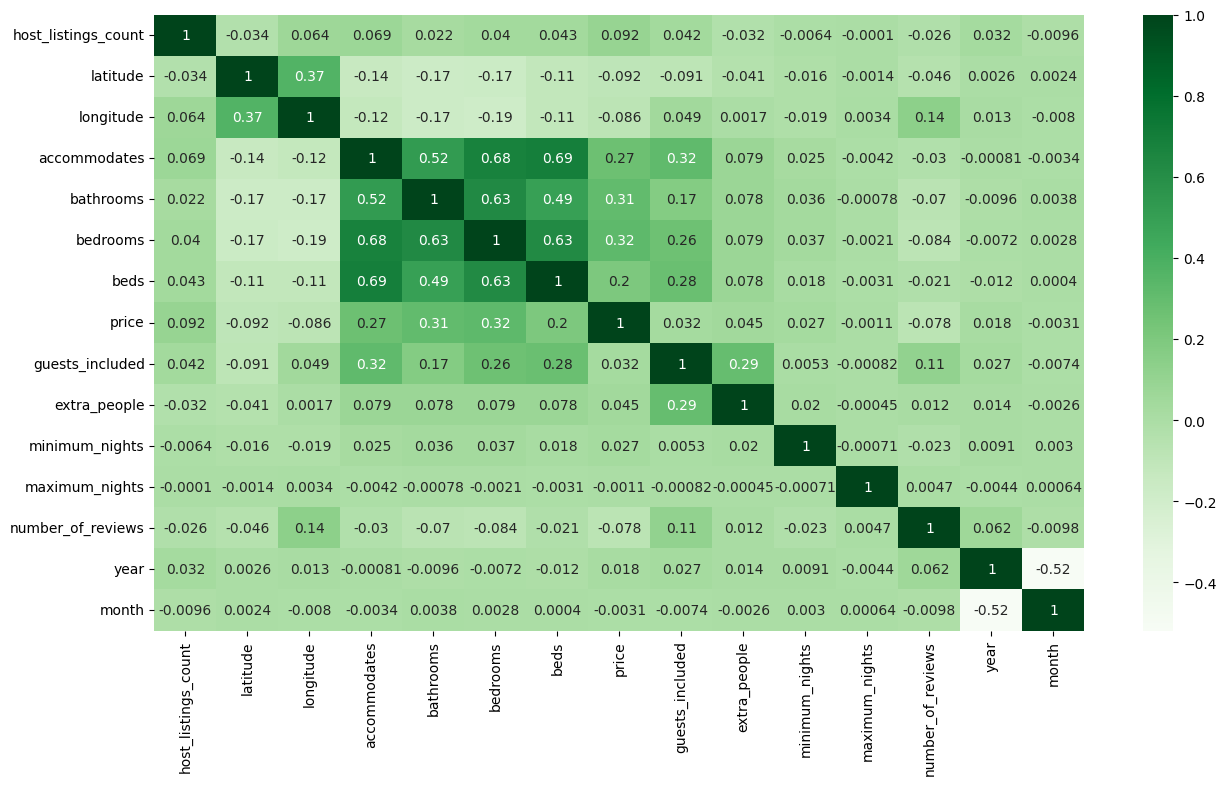

In [117]:
# analise de correlacao
plt.figure(figsize=(15,8))
sns.heatmap(base_airbnb.corr(numeric_only=True), annot=True, cmap='Greens')

 #### Definição de funcoes para determinar outliers

 Utilizando o conceito de Quartil (que é qualquer um dos três valores que divide o conjunto ordenado de dados em quatro partes iguais) para definir os outliers.


In [118]:
def calculate_limits(column: Series):
    first_quantile = column.quantile(0.25)  # definindo o primeiro quartil
    third_quantile = column.quantile(0.75)  # definindo o terceiro quartil
    amplitude = third_quantile - first_quantile
    inferior_limit = first_quantile - (1.5 * amplitude)
    superior_limit = third_quantile + (1.5 * amplitude)
    return inferior_limit, superior_limit


def remove_outliers(df: DataFrame, column_name: str):
    old_lines_number = df.shape[0]
    column: Series = df[column_name]
    inferior_limit, superior_limit = calculate_limits(column)
    filtered_df = df.loc[(column >= inferior_limit) & (column <= superior_limit), :]
    removed_line_number = old_lines_number - filtered_df.shape[0]
    return filtered_df, removed_line_number

In [119]:
def boxplot_builder(column: Series):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=column, ax=ax1)
    ax2: Axes
    ax2.set_xlim(calculate_limits(column))
    sns.boxplot(x=column, ax=ax2)


# TODO: melhorar grafico de histograma
def histogram_builder(column):
    plt.figure(figsize=(15, 5))
    # sns.distplot(column, hist=True)
    sns.histplot(column, kde=True, stat="density")
    # sns.displot(column)


def barplot_builder(column: Series, show_all: bool = False):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=column.value_counts().index, y=column.value_counts())
    if show_all is False:
        ax.set_xlim(calculate_limits(column))


Vamos primeiro analisar as colunas com quantidades continuas, ou seja, com variação decimal, que seriam as colunas de price e extra_people

### Price

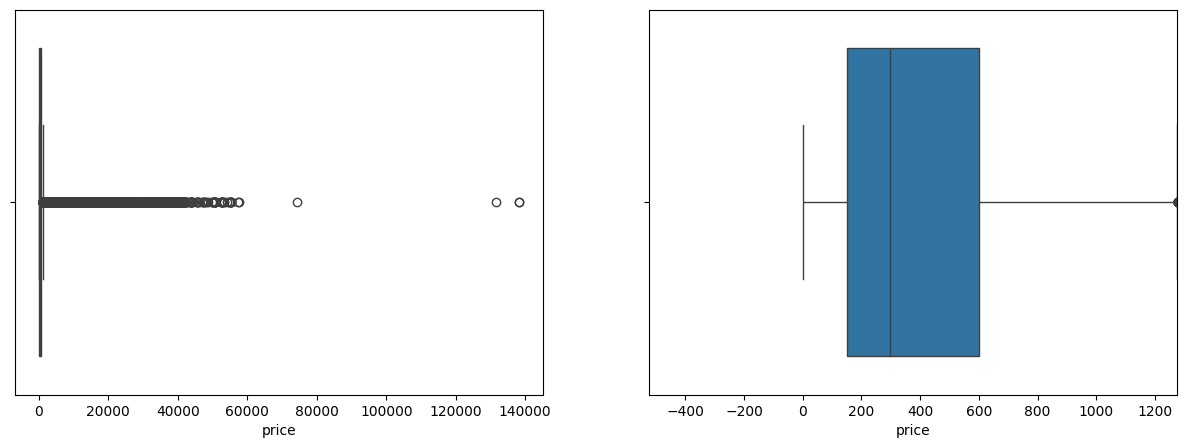

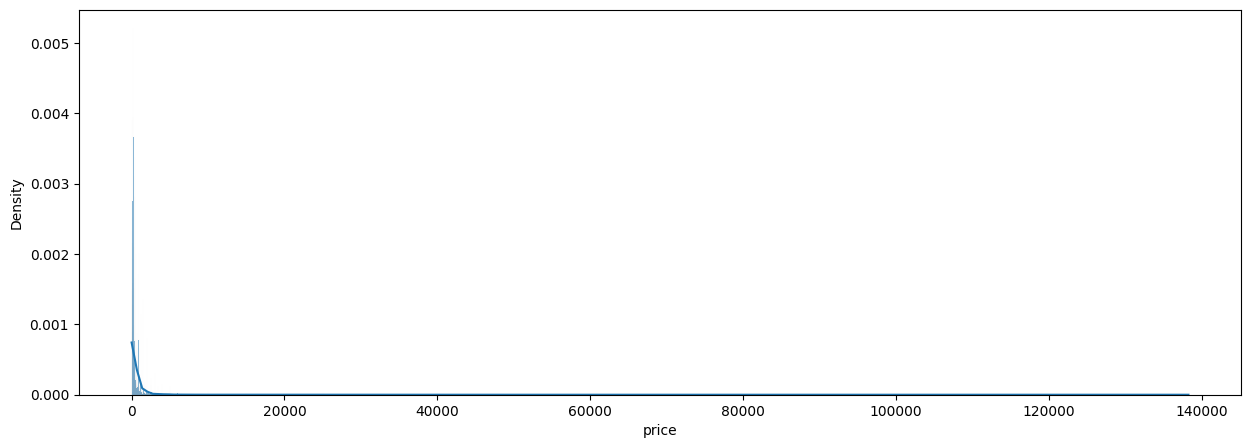

In [120]:
boxplot_builder(base_airbnb["price"])
histogram_builder(base_airbnb["price"])

Como estamos construindo um modelo para imóveis comum, acredito que os valores acima do limite superior serão apenas de apartamentos de alto padrao, que nao se encaixam no nosso objetivo principal. Por isso, iremos excluir os outliers

In [121]:
base_airbnb, removed_lines = remove_outliers(base_airbnb, "price")
print("numero de linhas removidas: ", removed_lines)

numero de linhas removidas:  87282


Um comentário feito pelo autor do dataset que achei interessante salientar:
em precos cheios existem picos, uma ves que as proprias pessoas definem os precos, e intuitivamente é costumeiro determinar precos cheios e é poossivel analisar isso no histograma agora filtrado.

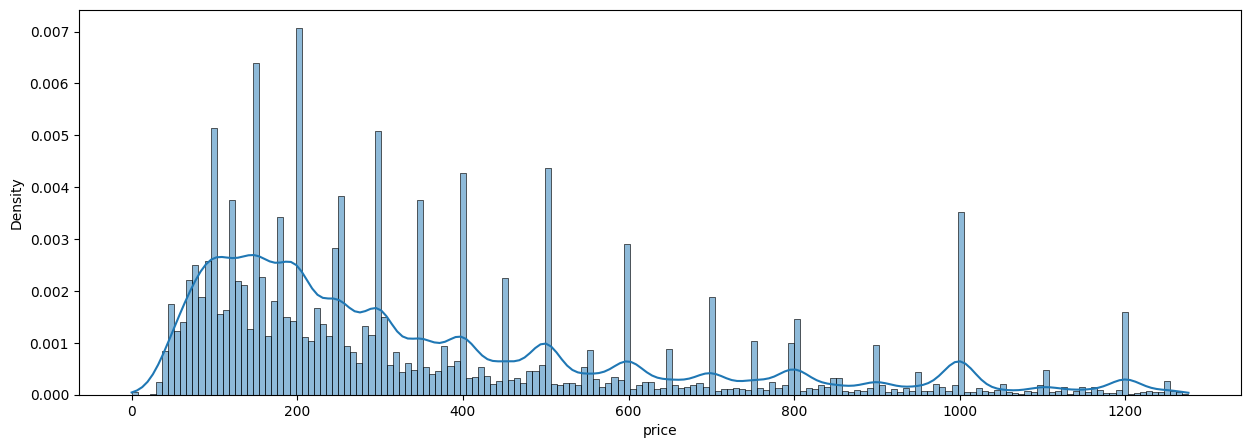

In [122]:
histogram_builder(base_airbnb["price"])

#### extra_people

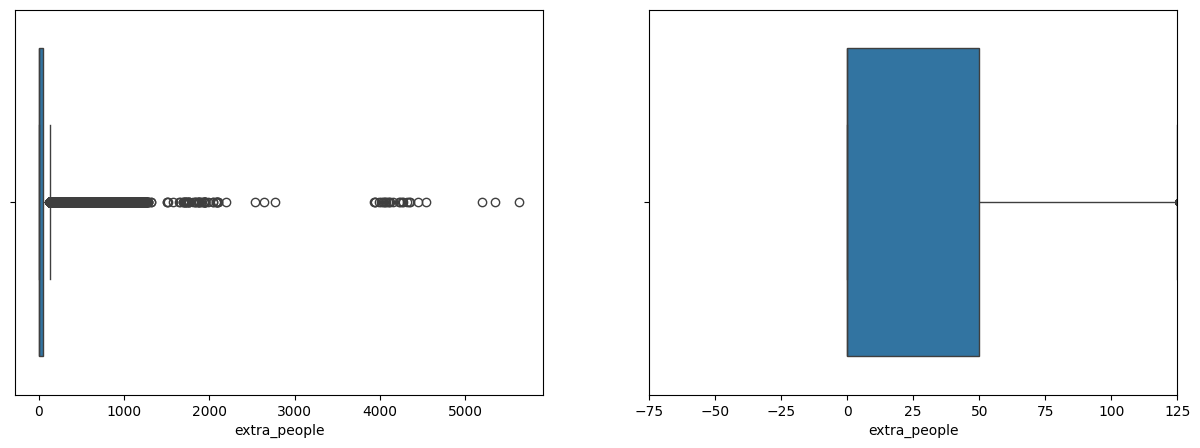

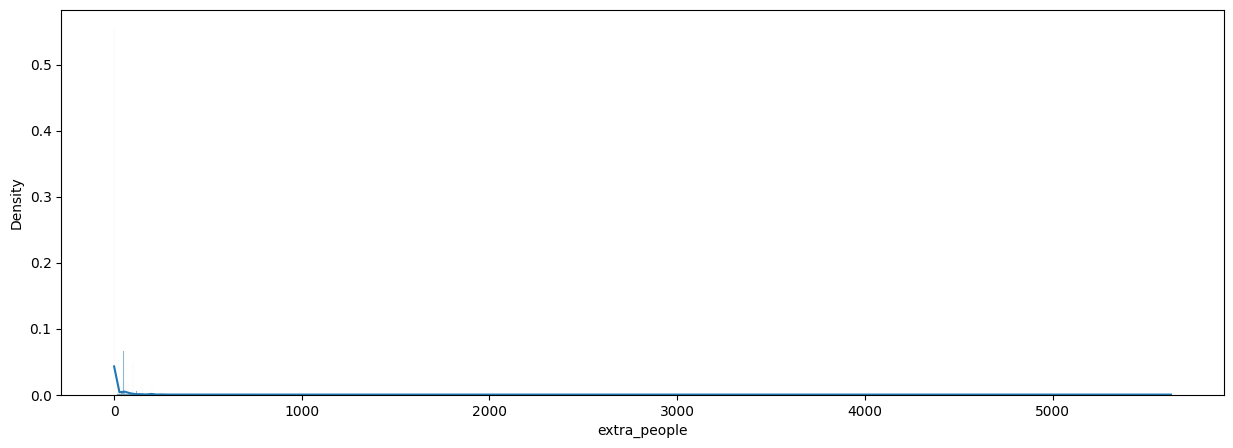

In [123]:
boxplot_builder(base_airbnb["extra_people"])
histogram_builder(base_airbnb["extra_people"])

In [124]:
base_airbnb, removed_lines = remove_outliers(base_airbnb, "extra_people")
print("numero de linhas removidas: ", removed_lines)

numero de linhas removidas:  59194


depois partiremos para analise de outiliers das colunas com valores discretos, com acrescimos inteiros, que seriam: accomodates, bedrooms, guests_included, etc

#### host_listings_count

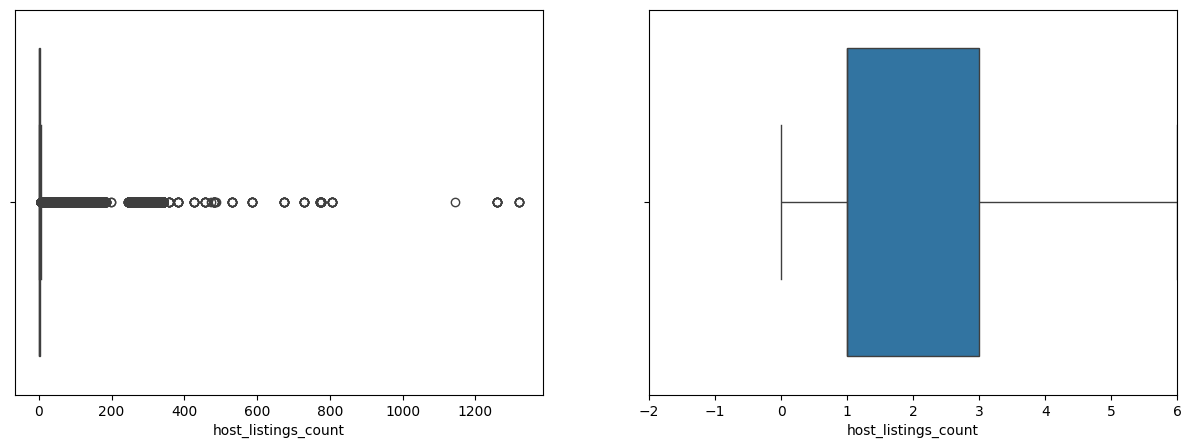

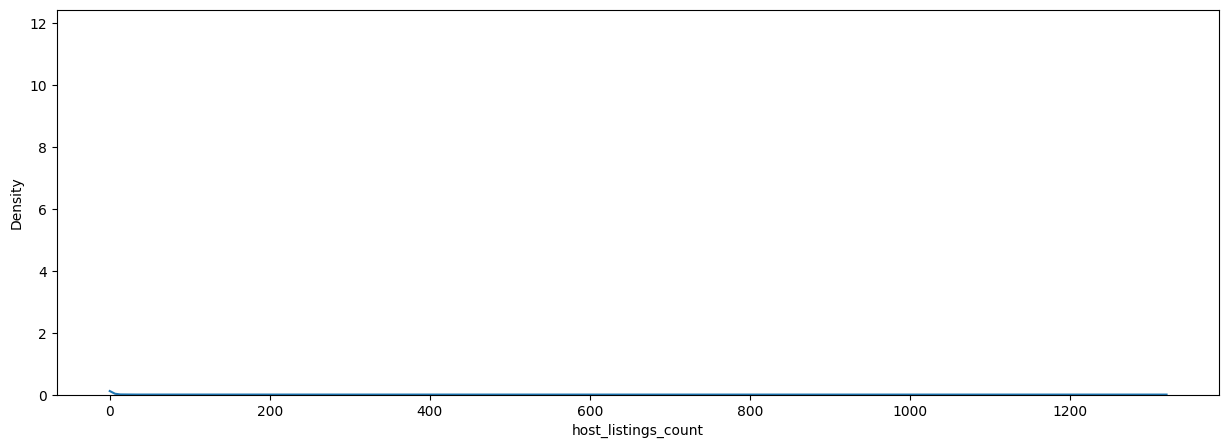

In [125]:
boxplot_builder(base_airbnb["host_listings_count"])
histogram_builder(base_airbnb["host_listings_count"])

visualizacao das features discretas nao ficou boa utilizando o grafico de histograma, sera entao utilizado o grafico de barras para avisualizacao, limitando o eixo x para ser exibir apenas dentro dos limites

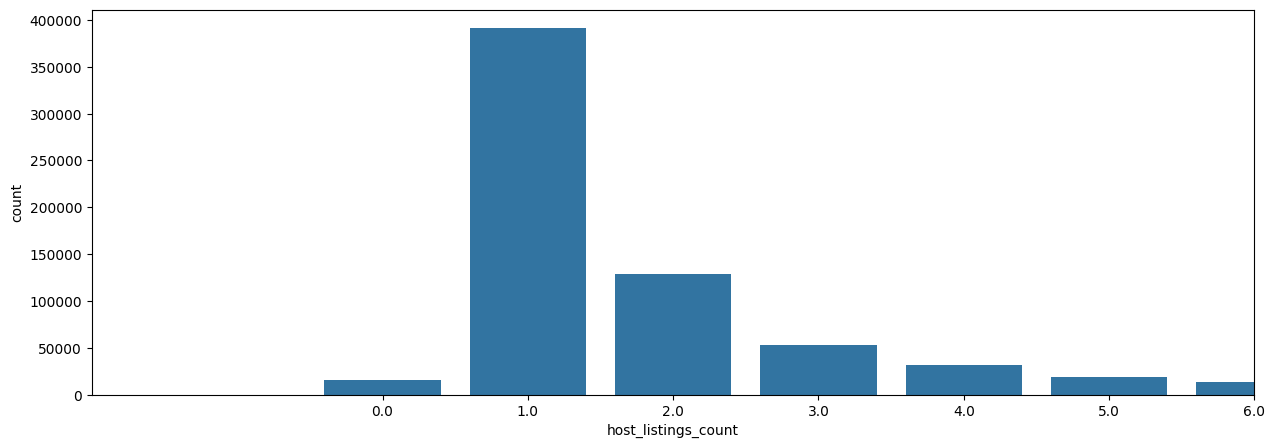

In [126]:
barplot_builder(base_airbnb["host_listings_count"])

podemos excluir os outilers porque para os objetivos do nosso projeto, hosts com mais de 6 imoveis no airbnb nao são o publico alvo do nosso objetivo (imagina-se que sejam imobiliários ou profissionais que gerenciam imoveis no airbnb)

In [127]:
base_airbnb, removed_lines = remove_outliers(base_airbnb, "host_listings_count")
print("numero de linhas removidas: ", removed_lines)

numero de linhas removidas:  97723


#### accommodates

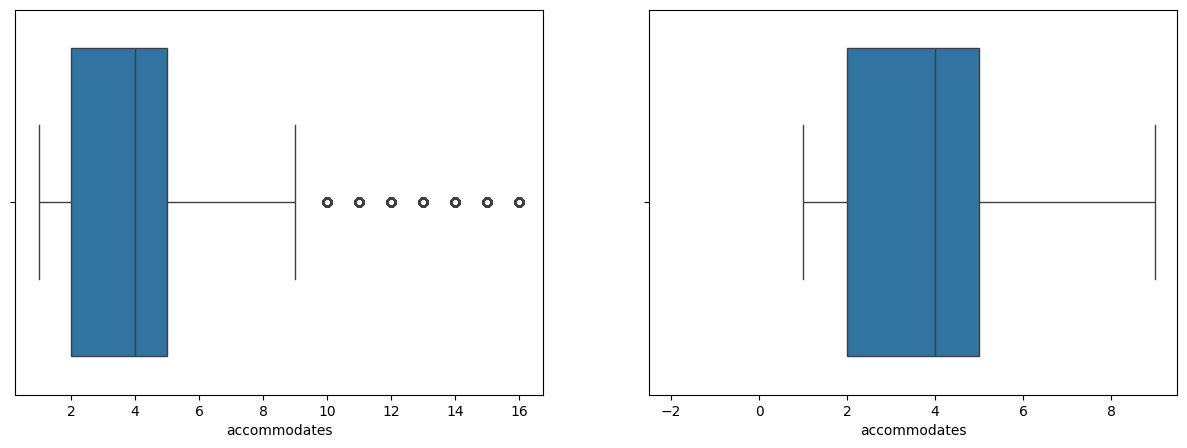

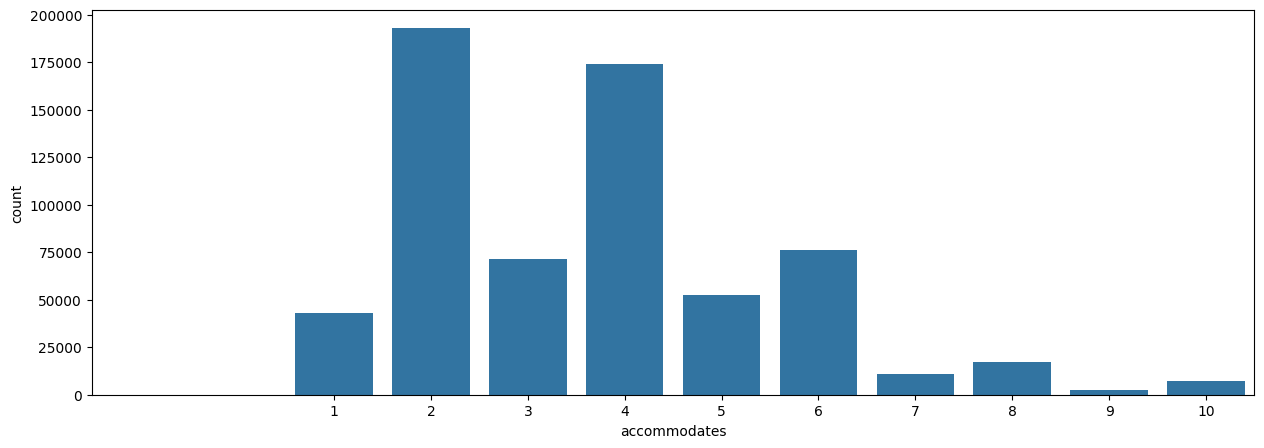

In [128]:
boxplot_builder(base_airbnb["accommodates"])
barplot_builder(base_airbnb["accommodates"])

In [129]:
base_airbnb, removed_lines = remove_outliers(base_airbnb, "accommodates")
print("numero de linhas removidas: ", removed_lines)

numero de linhas removidas:  13146


#### bathrooms

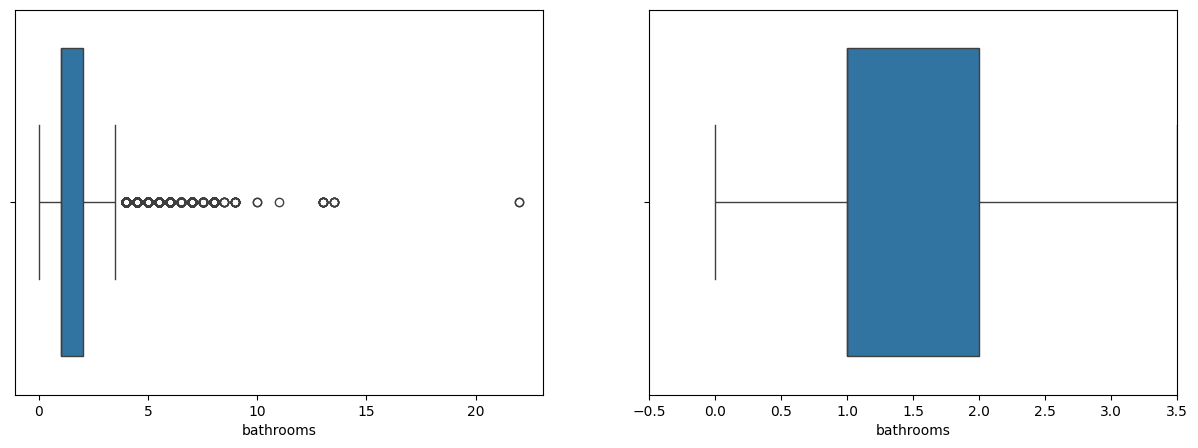

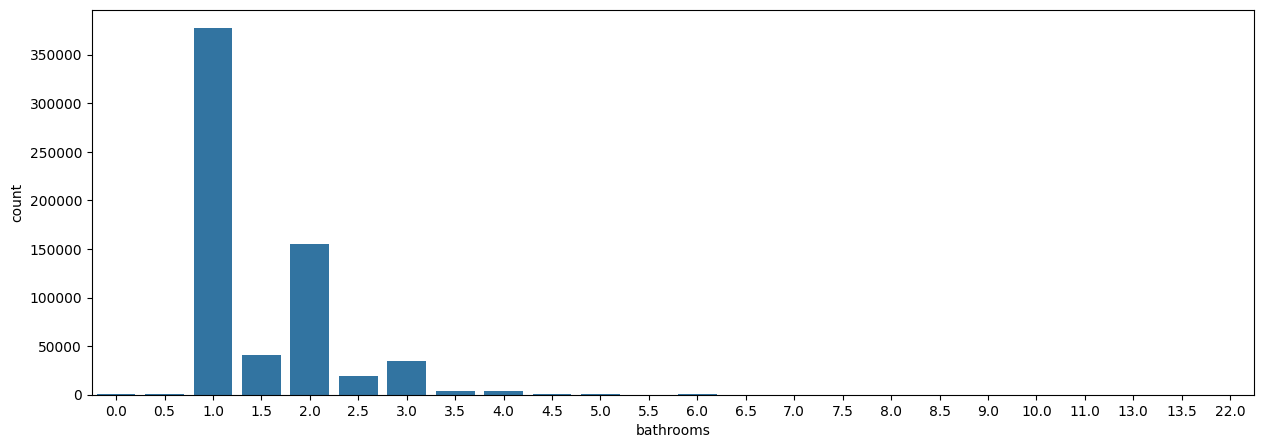

In [130]:
boxplot_builder(base_airbnb["bathrooms"])
barplot_builder(base_airbnb["bathrooms"], show_all=True)

In [131]:
base_airbnb, removed_lines = remove_outliers(base_airbnb, "bathrooms")
print("numero de linhas removidas: ", removed_lines)

numero de linhas removidas:  6894


#### bedrooms

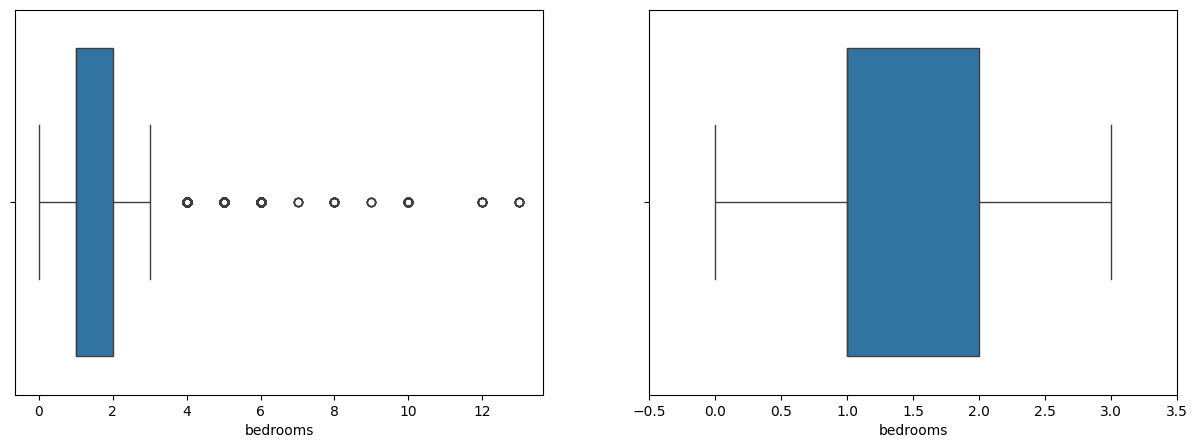

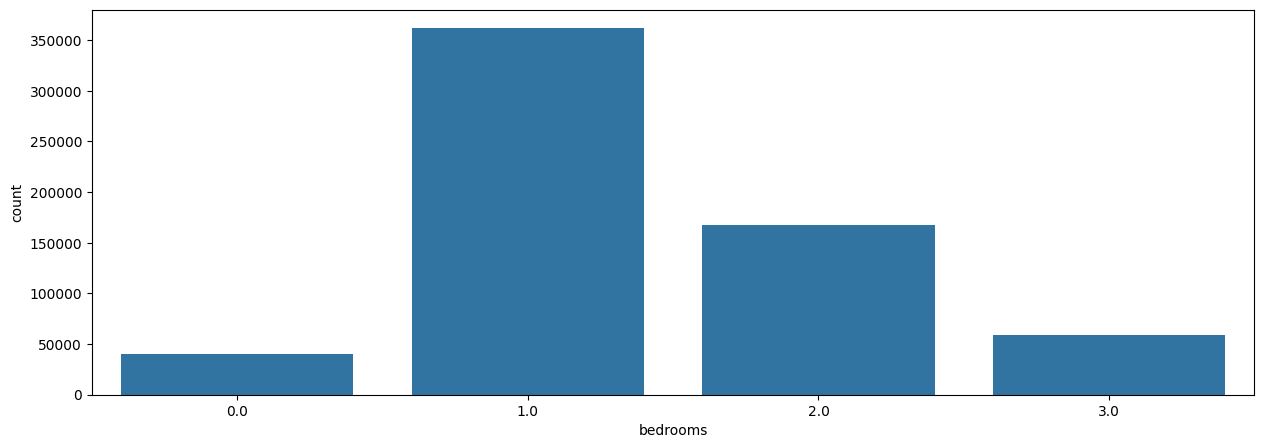

In [132]:
boxplot_builder(base_airbnb["bedrooms"])
barplot_builder(base_airbnb["bedrooms"])

In [133]:
base_airbnb, removed_lines = remove_outliers(base_airbnb, "bedrooms")
print("numero de linhas removidas: ", removed_lines)

numero de linhas removidas:  5482


#### beds

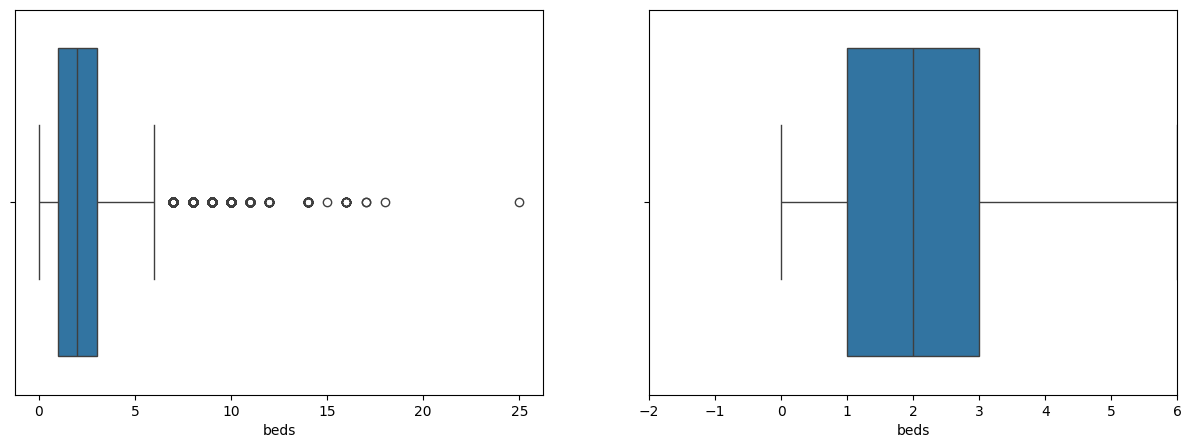

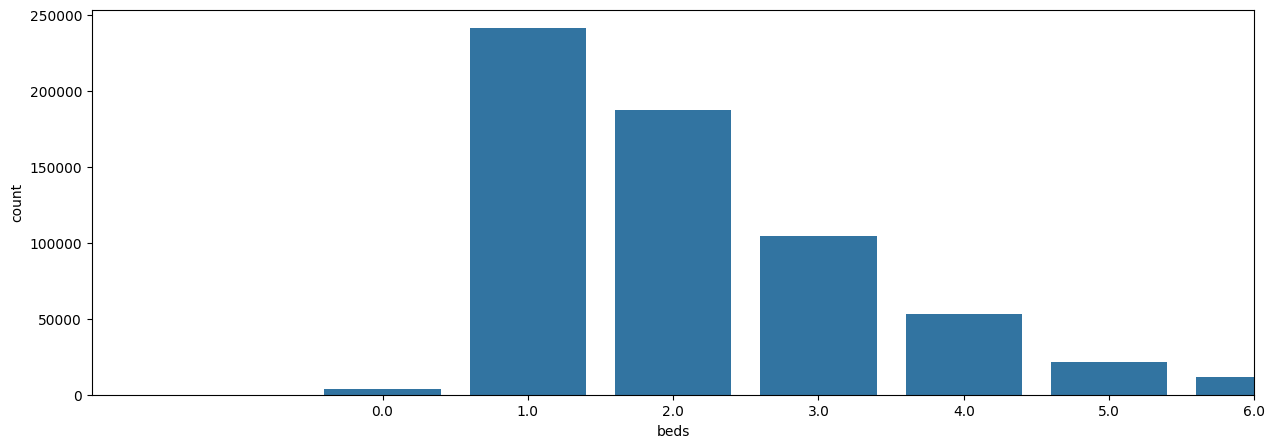

In [134]:
boxplot_builder(base_airbnb["beds"])
barplot_builder(base_airbnb["beds"])

In [135]:
base_airbnb, removed_lines = remove_outliers(base_airbnb, "beds")
print("numero de linhas removidas: ", removed_lines)

numero de linhas removidas:  5622


#### ghests_included

/tmp/ipykernel_15326/948386170.py:6: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(calculate_limits(column))
/tmp/ipykernel_15326/948386170.py:22: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(calculate_limits(column))


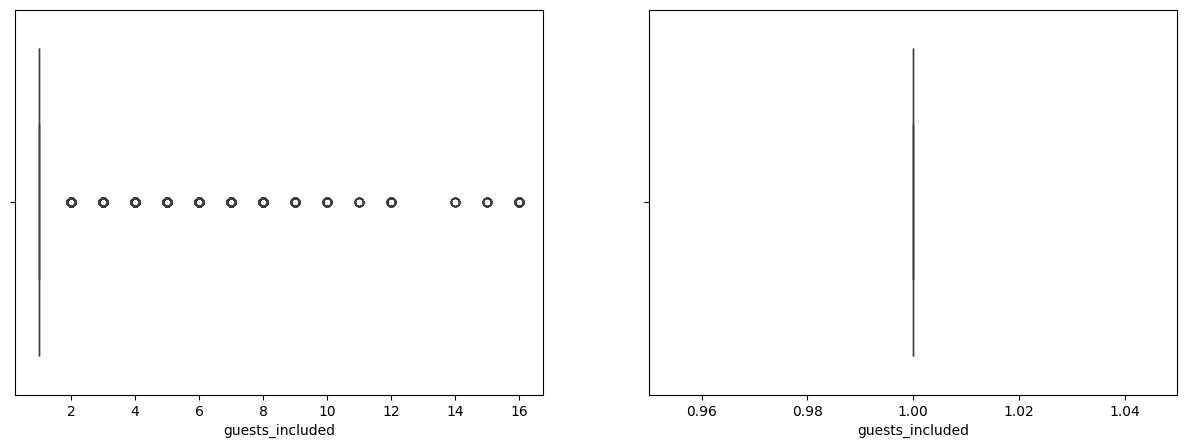

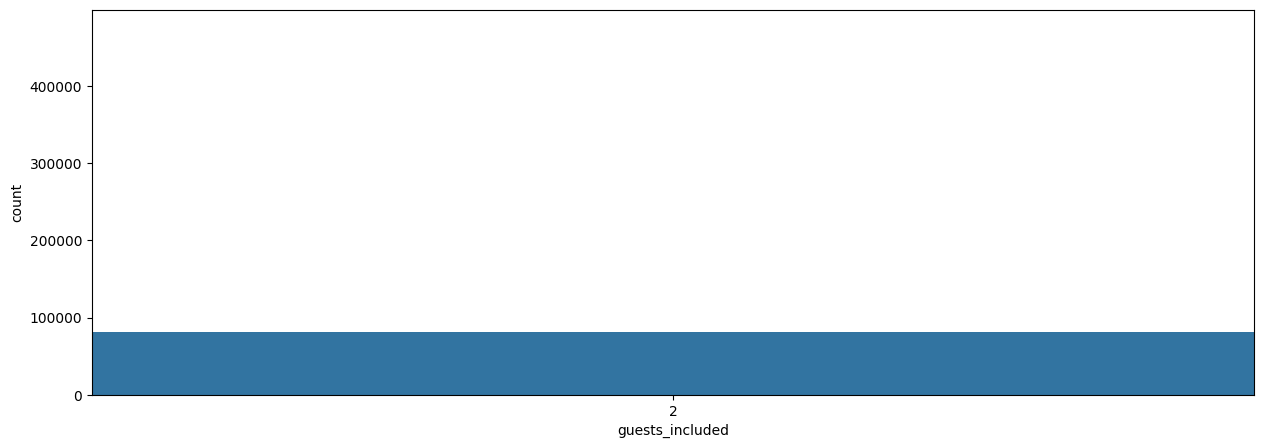

In [136]:
boxplot_builder(base_airbnb["guests_included"])
barplot_builder(base_airbnb["guests_included"])

In [137]:
print(calculate_limits(base_airbnb["guests_included"]))

(np.float64(1.0), np.float64(1.0))


analisando os limites, percebemos que ambos os limites dao como 1
muitos dados seriam perdidos se usassemos os limites da forma que estamos usando, para excluir os outliers fora deles
a causa disso pode ser erros de preenchimento desse dado em específico dos locadores no momento de definir o imovel (de onde os dados são extraidos), possivelmente usando um valor padrao já apontado.
removendo os outliers de guest included podemos ter problemas por remover muitos dados que nesse caso seriam interessantes para a diversidade do nosso modelo
entao nao iremos remover os outilers e iremos remover essa feature da nossa analise

In [138]:
base_airbnb = base_airbnb.drop("guests_included", axis=1)
base_airbnb.shape

(622366, 22)

#### minimum_nights

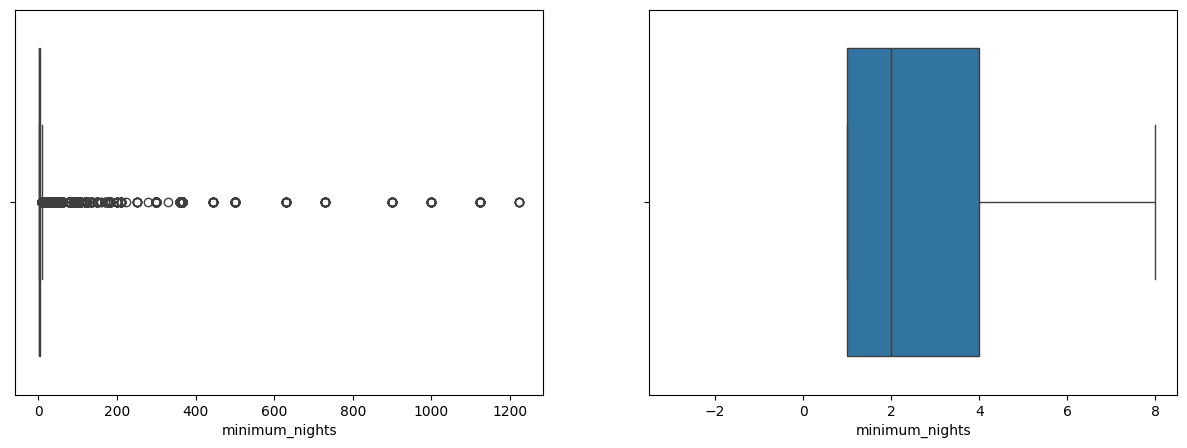

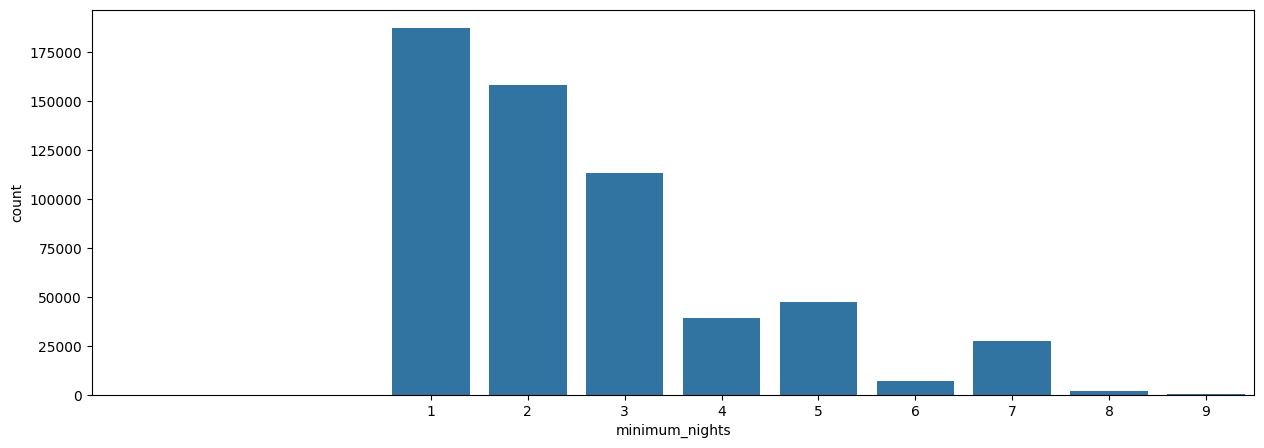

In [139]:
boxplot_builder(base_airbnb["minimum_nights"])
barplot_builder(base_airbnb["minimum_nights"])

In [140]:
base_airbnb, removed_lines = remove_outliers(base_airbnb, "minimum_nights")
print("numero de linhas removidas: ", removed_lines)

numero de linhas removidas:  40383


#### maximum_nights

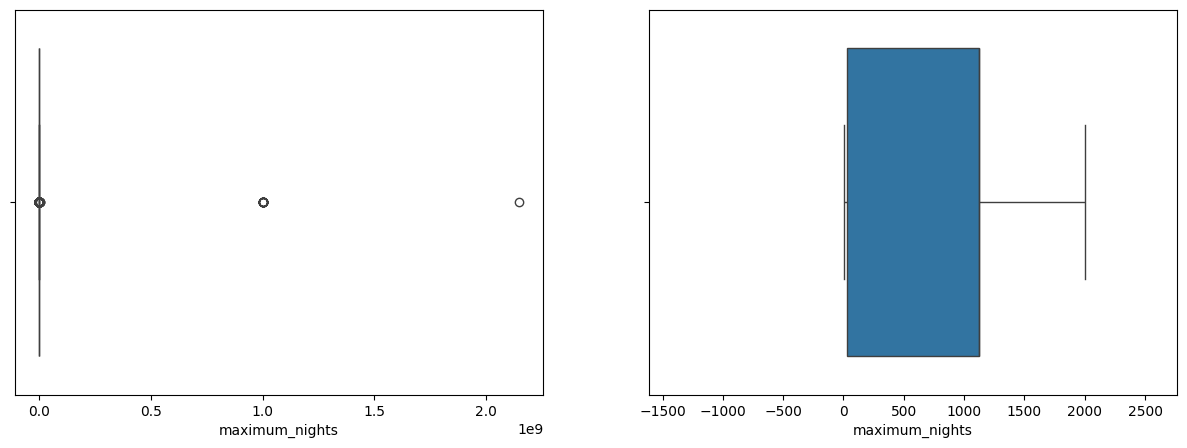

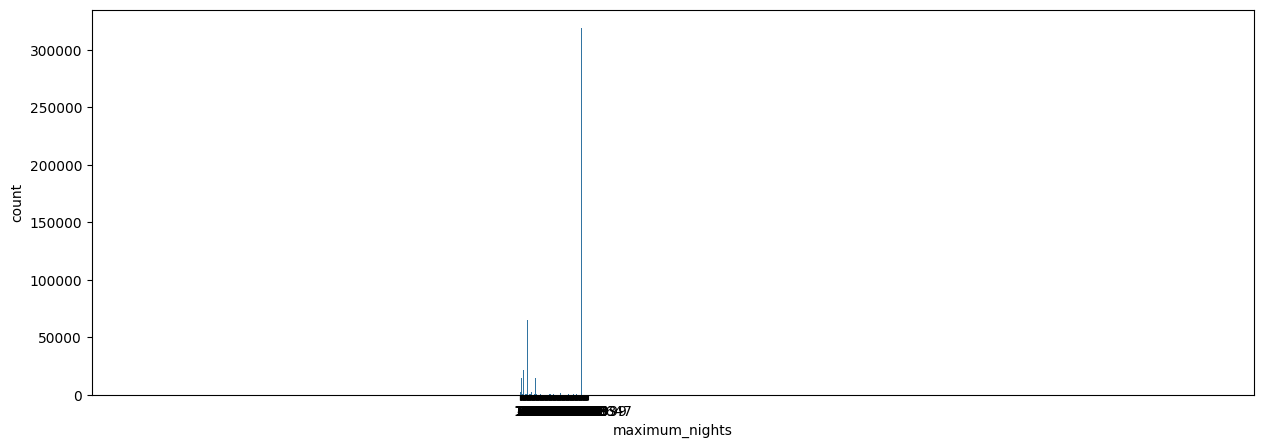

In [141]:
boxplot_builder(base_airbnb["maximum_nights"])
barplot_builder(base_airbnb["maximum_nights"])

temos muitos valores zerados e outra grande porcao de valores grandes
a mesma suposicao utilizada para guests included será utilizada aqui, de que no preenchimento e cadastro dos imoveis, a parte dos imoveis que estamos interessados e filtrando ate aqui nao deve cadastrar corretamente e um valor padrao (nesse caso 0 aparentemente) esta cadastrado
nao parece ser uma metrica boa para nossa analise, deve apenas prejudicar nosso modelo se tentarmos adaptar ou retirar todos os valores atraves da mesma logica

In [142]:
base_airbnb = base_airbnb.drop("maximum_nights", axis=1)
base_airbnb.shape

(581983, 21)

#### number_of_reviews  

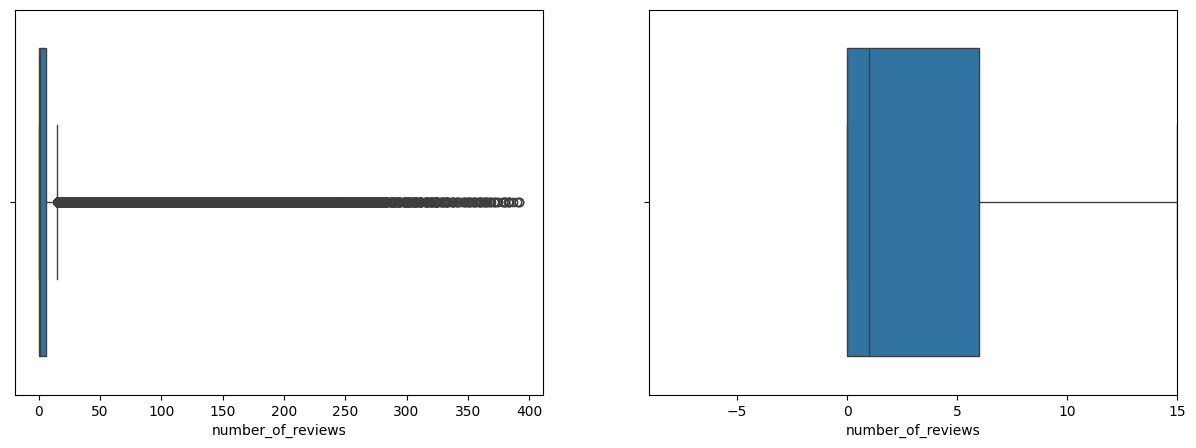

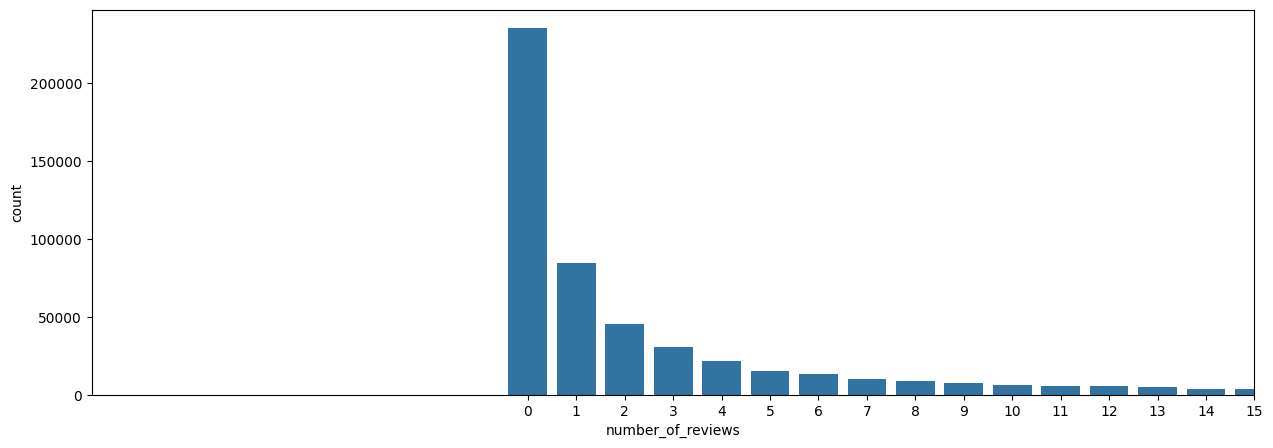

In [143]:
boxplot_builder(base_airbnb["number_of_reviews"])
barplot_builder(base_airbnb["number_of_reviews"])

retirar os imoveis com numeros de reviews acima do nossos limites nao faz sentido, ja que pode ser apenas um imovel com mais tempo de aplicativo, talvez tendo apenas coisas positivas, como um preco muito bom, o que seria otimo para o nosso modelo
tirando esses dados, tiraria os melhores hosts do nosso modelo

iremos prefirir tirar essa feature porque queremos construit um modelo que nao tenha nenhum review, ja que queremos criar o modelo para qualquer pessoa que queira disponibilizar um umovel, independente do numero de reviews previos
tentaremos criar um modelo que nao dependa ou nao tenha interferencia do numero de reviews

In [144]:
base_airbnb = base_airbnb.drop("number_of_reviews", axis=1)
base_airbnb.shape

(581983, 20)